#  <center> Speech Emotion Recognition <center>

# Importing Libraries

In [ ]:
!apt-get update
!apt-get install -y libsndfile1

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

In [ ]:
!unzip  "/content/MyDrive/MyDrive/cremaD.zip" 

In [ ]:
!unzip -y "/content/MyDrive/MyDrive/Ravdess.zip"

In [ ]:
!unzip "/content/MyDrive/MyDrive/savee.zip"

In [ ]:
!unzip  "/content/MyDrive/MyDrive/TESS.zip"

In [3]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

!git clone https://github.com/raphaelvallat/entropy.git entropy/
!cd entropy/
!pip install -r requirements.txt



## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [ ]:
# Paths for data.
Ravdess = "/content/audio_speech_actors_01-24/"
Crema = "/content/AudioWAV/"
Tess = "/content/TESS Toronto emotional speech set data/"
Savee = "/content/ALL/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,/content/audio_speech_actors_01-24/Actor_13/03...
1,fear,/content/audio_speech_actors_01-24/Actor_13/03...
2,surprise,/content/audio_speech_actors_01-24/Actor_13/03...
3,fear,/content/audio_speech_actors_01-24/Actor_13/03...
4,happy,/content/audio_speech_actors_01-24/Actor_13/03...


## <center>2. Crema DataFrame</center>

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,sad,/content/AudioWAV/1032_MTI_SAD_XX.wav
1,fear,/content/AudioWAV/1083_IEO_FEA_MD.wav
2,fear,/content/AudioWAV/1037_ITS_FEA_XX.wav
3,disgust,/content/AudioWAV/1007_IWW_DIS_XX.wav
4,fear,/content/AudioWAV/1025_TIE_FEA_XX.wav


##  <center> 3. TESS dataset <center>

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,disgust,/content/TESS Toronto emotional speech set dat...
1,disgust,/content/TESS Toronto emotional speech set dat...
2,disgust,/content/TESS Toronto emotional speech set dat...
3,disgust,/content/TESS Toronto emotional speech set dat...
4,disgust,/content/TESS Toronto emotional speech set dat...


##  <center> 4. Savee dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head(10)

,Emotions,Path
0,surprise,/content/ALL/JE_su12.wav
1,fear,/content/ALL/KL_f02.wav
2,neutral,/content/ALL/JE_n17.wav
3,surprise,/content/ALL/DC_su08.wav
4,happy,/content/ALL/JK_h09.wav
5,neutral,/content/ALL/DC_n29.wav
6,disgust,/content/ALL/DC_d01.wav
7,neutral,/content/ALL/DC_n23.wav
8,surprise,/content/ALL/JE_su08.wav
9,neutral,/content/ALL/DC_n28.wav


In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head(-20)

,Emotions,Path
0,angry,/content/audio_speech_actors_01-24/Actor_13/03...
1,fear,/content/audio_speech_actors_01-24/Actor_13/03...
2,surprise,/content/audio_speech_actors_01-24/Actor_13/03...
3,fear,/content/audio_speech_actors_01-24/Actor_13/03...
4,happy,/content/audio_speech_actors_01-24/Actor_13/03...
...,...,...
455,neutral,/content/ALL/KL_n20.wav
456,angry,/content/ALL/DC_a14.wav
457,fear,/content/ALL/JK_f04.wav
458,neutral,/content/ALL/KL_n27.wav


## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

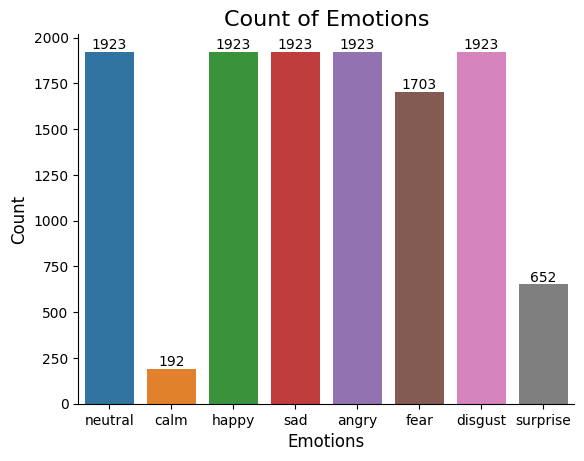

In [ ]:

le = LabelEncoder()
data_path['Emotions_encoded'] = le.fit_transform(data_path['Emotions'])

plt.title('Count of Emotions', size=16)
ax=sns.countplot(x='Emotions_encoded', data=data_path)
ax.set(xticklabels=["neutral", "calm", "happy","sad","angry","fear","disgust","surprise"])
ax.bar_label(ax.containers[0])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:

# def categorize_emotion(i):
#   if (i=='neutral') or (i=='calm') or (i=='happy') or (i=='surprise'):
#     category='Positive'
#   else:
#     category='Negative'
#   return category

data_path2 = data_path.copy()
# data_path2['Category'] = data_path2['Emotions'].apply(categorize_emotion)
data_path2.Emotions.replace({'neutral':'Positive', 'calm':'Positive','happy':'Positive', 'sad':'Negative', 'angry':'Negative','fear':'Negative','disgust':'Negative','surprise':'Positive'}, inplace=True)

data_path2.to_csv("data_path2.csv",index=False)
data_path2.head(20)

,Emotions,Path,Emotions_encoded
0,Negative,/content/audio_speech_actors_01-24/Actor_13/03...,0
1,Negative,/content/audio_speech_actors_01-24/Actor_13/03...,3
2,Positive,/content/audio_speech_actors_01-24/Actor_13/03...,7
3,Negative,/content/audio_speech_actors_01-24/Actor_13/03...,3
4,Positive,/content/audio_speech_actors_01-24/Actor_13/03...,4
5,Positive,/content/audio_speech_actors_01-24/Actor_13/03...,4
6,Positive,/content/audio_speech_actors_01-24/Actor_13/03...,7
7,Positive,/content/audio_speech_actors_01-24/Actor_13/03...,4
8,Positive,/content/audio_speech_actors_01-24/Actor_13/03...,1
9,Negative,/content/audio_speech_actors_01-24/Actor_13/03...,6


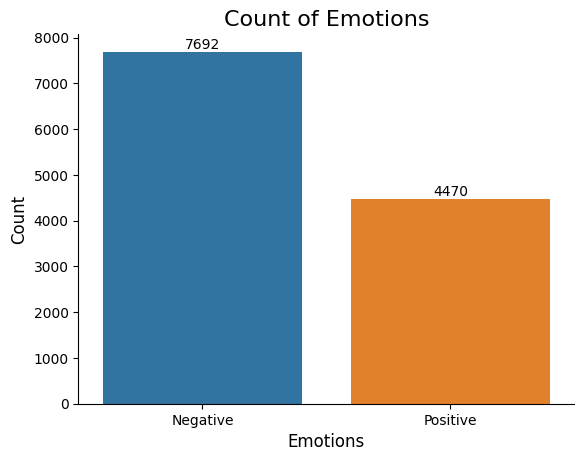

In [ ]:
le = LabelEncoder()
data_path2['Emotions_encoded2'] = le.fit_transform(data_path2['Emotions'])

plt.title('Count of Emotions', size=16)
ax=sns.countplot(x='Emotions_encoded2', data=data_path2)
ax.set(xticklabels=["Negative", "Positive"])
ax.bar_label(ax.containers[0])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

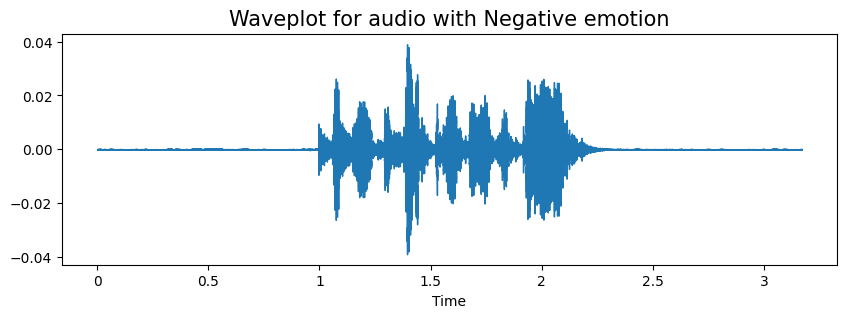

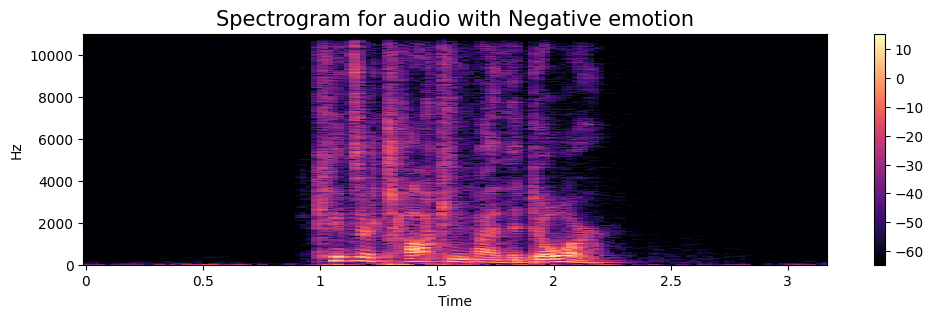

In [ ]:
emotion='Negative'
path = np.array(data_path2.Path[data_path2.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

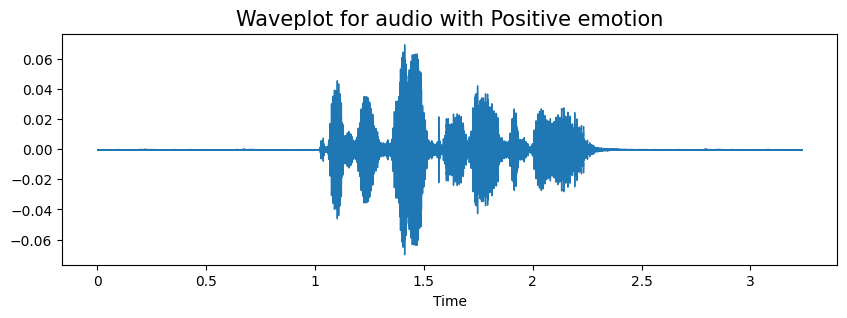

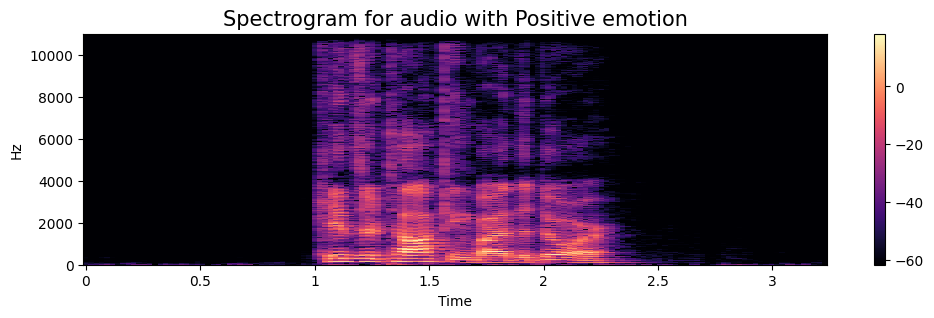

In [ ]:
emotion='Positive'
path = np.array(data_path2.Path[data_path2.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data,rate = 0.8):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps= pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path2.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

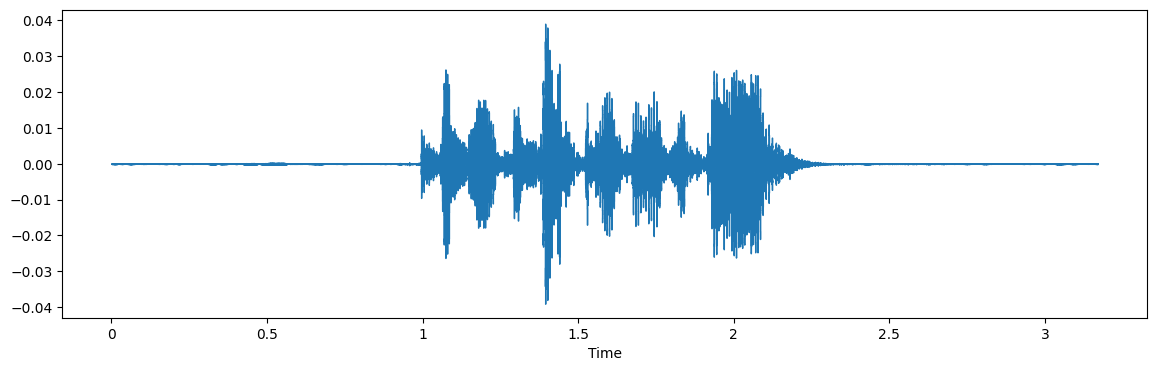

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

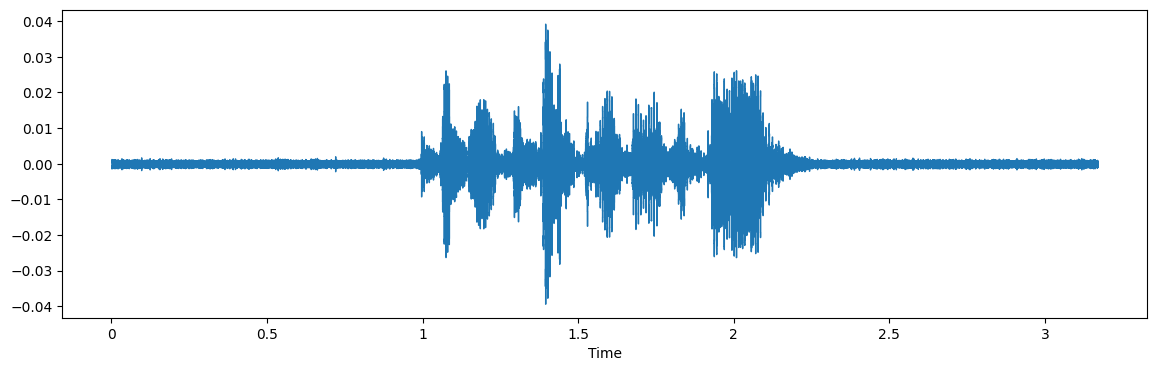

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

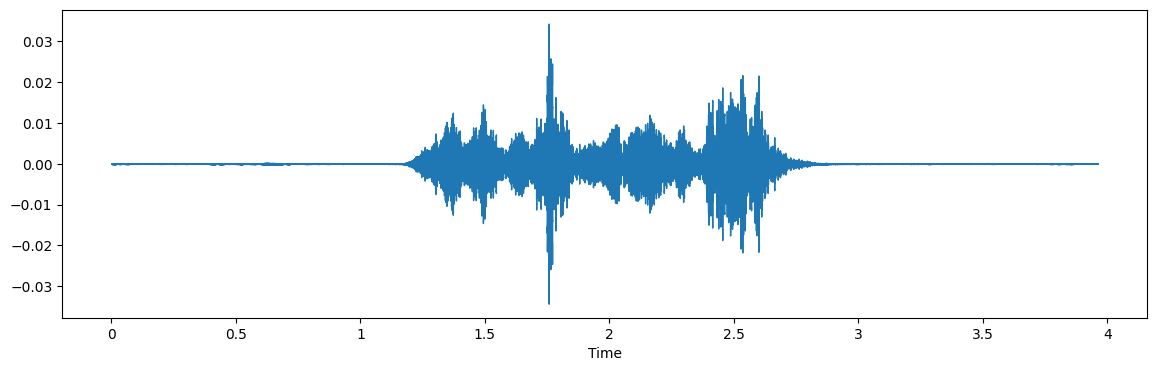

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

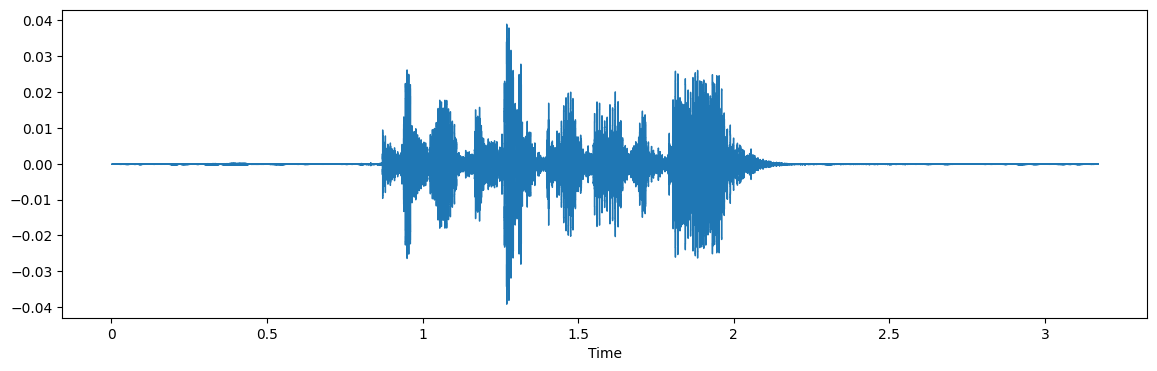

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

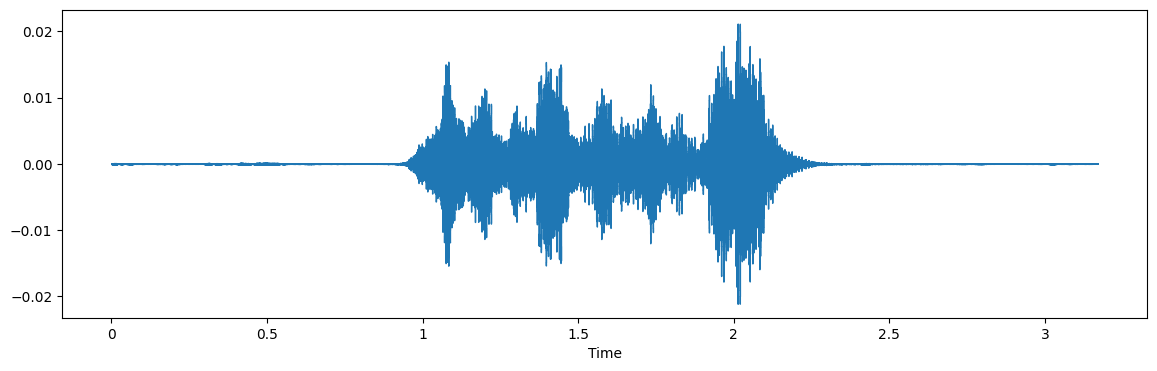

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

In [ ]:
# rms =librosa.feature.rms(y=data).T
# rms.shape


# #result = np.hstack((result, rms))

(137, 1)

In [ ]:
# def rmse(data):
#     hop_length = 512
#     frame_length = 1024
#     n_fft = frame_length

#     rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length, center=True)

#     rmse = rmse[0]

#     energy = np.array([ sum(abs(x[i:i+frame_length]**2))
#     for i in range(0, len(x), hop_length)])
   


In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # # data with stretching and pitching
    # new_data = stretch(data)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data_stretch_pitch)
    # result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path2.Path, data_path2.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
len(X), len(Y), data_path2.Path.shape

(24324, 24324, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.165175,0.540101,0.586332,0.676254,0.728112,0.759640,0.645199,0.526068,0.512936,0.555358,...,0.010385,0.009084,0.011945,0.013049,0.015698,0.019773,0.014185,0.007153,0.000279,Negative
1,0.324775,0.658020,0.729874,0.776700,0.829102,0.819803,0.636599,0.560759,0.571611,0.609994,...,0.054850,0.057796,0.058597,0.059465,0.060256,0.067089,0.059242,0.054856,0.049764,Negative
2,0.254006,0.723885,0.722582,0.746816,0.719508,0.695466,0.717808,0.763478,0.750665,0.749715,...,0.000006,0.000011,0.000035,0.000022,0.000012,0.000015,0.000010,0.000010,0.000001,Negative
3,0.295275,0.760300,0.748793,0.778316,0.775360,0.777594,0.764027,0.737075,0.749996,0.747815,...,0.000010,0.000016,0.000040,0.000028,0.000017,0.000020,0.000015,0.000015,0.000006,Negative
4,0.225197,0.699677,0.705807,0.721140,0.749028,0.783149,0.721572,0.709440,0.708163,0.714498,...,0.000038,0.000045,0.000068,0.000083,0.000081,0.000063,0.000063,0.000031,0.000003,Positive


In [4]:
Features = pd.read_csv("/content/MyDrive/MyDrive/Major_project_aryan/speech/speech_features.csv")

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.165175,0.540101,0.586332,0.676254,0.728112,0.759640,0.645199,0.526068,0.512936,0.555358,...,0.010385,0.009084,0.011945,0.013049,0.015698,0.019773,0.014185,0.007153,0.000279,Negative
1,0.324775,0.658020,0.729874,0.776700,0.829102,0.819803,0.636599,0.560759,0.571611,0.609994,...,0.054850,0.057796,0.058597,0.059465,0.060256,0.067089,0.059242,0.054856,0.049764,Negative
2,0.254006,0.723885,0.722582,0.746816,0.719508,0.695466,0.717808,0.763478,0.750665,0.749715,...,0.000006,0.000011,0.000035,0.000022,0.000012,0.000015,0.000010,0.000010,0.000001,Negative
3,0.295275,0.760300,0.748793,0.778316,0.775360,0.777594,0.764027,0.737075,0.749996,0.747815,...,0.000010,0.000016,0.000040,0.000028,0.000017,0.000020,0.000015,0.000015,0.000006,Negative
4,0.225197,0.699677,0.705807,0.721140,0.749028,0.783149,0.721572,0.709440,0.708163,0.714498,...,0.000038,0.000045,0.000068,0.000083,0.000081,0.000063,0.000063,0.000031,0.000003,Positive


* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [5]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [6]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((18243, 162), (18243, 2), (6081, 162), (6081, 2))

In [7]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((18243, 162), (18243, 2), (6081, 162), (6081, 2))

In [8]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((18243, 162, 1), (18243, 2), (6081, 162, 1), (6081, 2))

## Modelling

In [9]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(units=2, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [10]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0005, # minimium amount of change to count as an improvement
    patience=11, # how many epochs to wait before stopping
    restore_best_weights=True,
)
history=model.fit(x_train, y_train, batch_size=32, epochs=31, validation_data=(x_test, y_test), callbacks=[rlrp,early_stopping])


Epoch 1/31
571/571 [==============================] - 146s 252ms/step - loss: 0.6493 - accuracy: 0.6365 - val_loss: 0.6406 - val_accuracy: 0.6310 - lr: 0.0010
Epoch 2/31
571/571 [==============================] - 137s 241ms/step - loss: 0.6025 - accuracy: 0.6777 - val_loss: 0.5688 - val_accuracy: 0.6913 - lr: 0.0010
Epoch 3/31
571/571 [==============================] - 137s 240ms/step - loss: 0.5496 - accuracy: 0.7101 - val_loss: 0.5283 - val_accuracy: 0.7116 - lr: 0.0010
Epoch 4/31
571/571 [==============================] - 136s 237ms/step - loss: 0.5255 - accuracy: 0.7253 - val_loss: 0.5151 - val_accuracy: 0.7196 - lr: 0.0010
Epoch 5/31
571/571 [==============================] - 136s 238ms/step - loss: 0.5166 - accuracy: 0.7270 - val_loss: 0.5167 - val_accuracy: 0.7221 - lr: 0.0010
Epoch 6/31
571/571 [==============================] - 144s 253ms/step - loss: 0.5024 - accuracy: 0.7344 - val_loss: 0.5026 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 7/31
571/571 [==========================

In [11]:
model.save('Speech-Emotion-Recognition-Model.h5')

In [17]:
pd.DataFrame(history.history).reset_index().to_csv('history_speech_emotion.csv', header=True, index=False) #saving weights in history

In [ ]:
import keras
from keras.models import models

trained_model = models.load_model('/content/Speech-Emotion-Recognition-Model.h5')
trained_model.summary()

In [ ]:
history = pd.read_csv('/content/history_speech_emotion.csv')

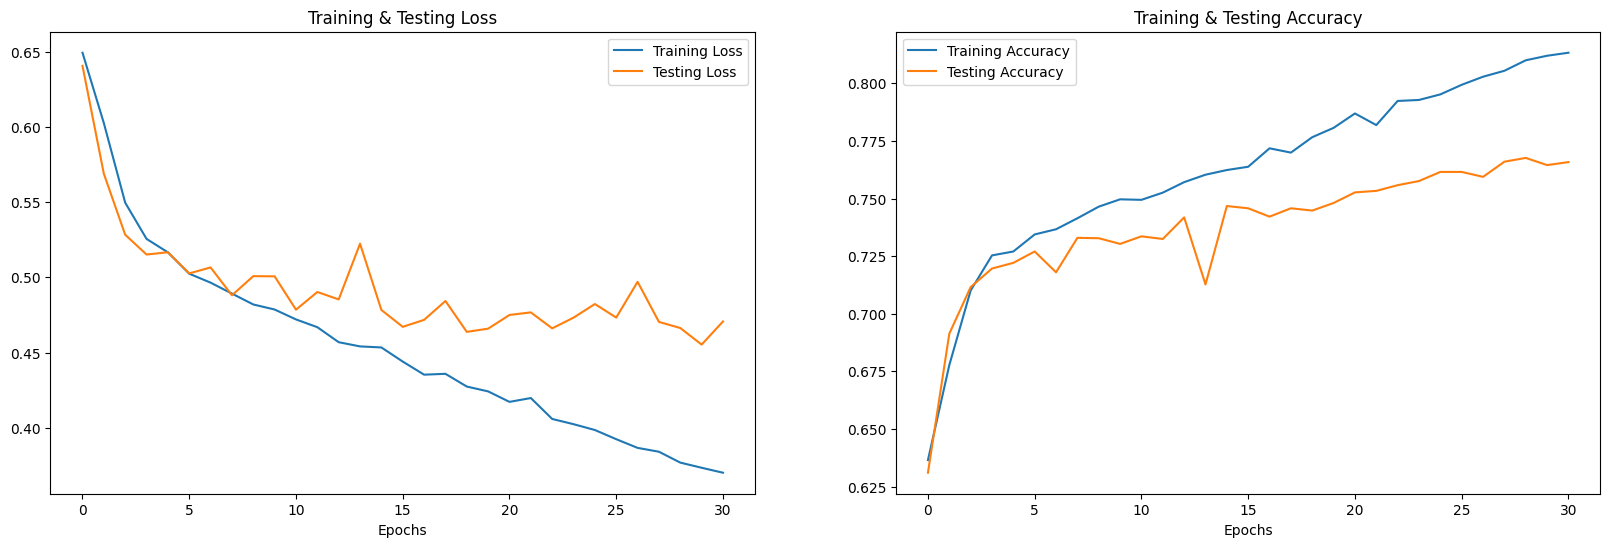

In [18]:
# print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(len(train_loss))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [19]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

191/191 [==============================] - 11s 58ms/step


In [20]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,Negative,Negative
1,Negative,Negative
2,Negative,Negative
3,Negative,Negative
4,Negative,Positive
5,Negative,Negative
6,Negative,Negative
7,Negative,Negative
8,Negative,Negative
9,Positive,Negative


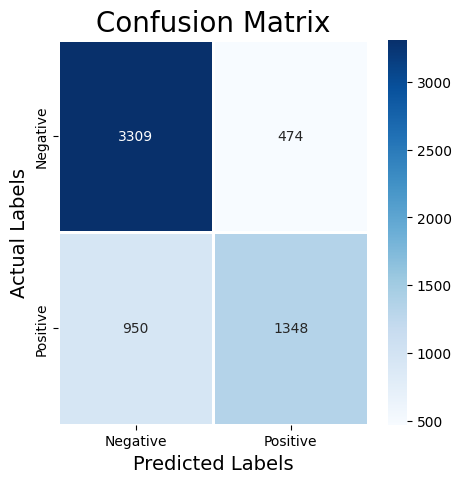

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (5, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.78      0.87      0.82      3783
    Positive       0.74      0.59      0.65      2298

    accuracy                           0.77      6081
   macro avg       0.76      0.73      0.74      6081
weighted avg       0.76      0.77      0.76      6081

